In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fineldataset/thefinal_dataset.csv


In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
import json


In [21]:
df = pd.read_csv('/kaggle/input/fineldataset/thefinal_dataset.csv',encoding= 'unicode_escape')
print(df.shape)
df.head()


(474399, 2)


,text,status
0,"""My mind is a never-ending cycle of worry, and...",anxiety
1,Despite the sun shining and birds singing outs...,bipolar disorder
2,"I'm drowning in responsibilities, each one dem...",stress
3,"""My emotions shift like the wind, leaving me u...",personality disorder
4,"I'm trapped in a whirlwind of thoughts, unable...",anxiety


In [22]:
# ✅ change column names if needed
TEXT_COL = "text"
LABEL_COL = "status"

df = df[[TEXT_COL, LABEL_COL]].dropna()
df[TEXT_COL] = df[TEXT_COL].astype(str)

print(df.shape)
df[LABEL_COL].value_counts()


(474398, 2)


status
depression              144271
suicidal                 72892
adhd                     61705
bipolar disorder         36350
normal                   30201
ocd                      25367
ptsd                     21314
anxiety                  18693
stress                   16050
personality disorder     14810
aspergers                13418
schizophrenia             7682
addiction                 6561
alcoholism                5084
Name: count, dtype: int64

In [23]:
labels_list = sorted(df[LABEL_COL].unique())  # or keep your own order
label2id = {lbl: i for i, lbl in enumerate(labels_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

df["label"] = df[LABEL_COL].map(label2id)

print("Num classes:", len(labels_list))
df.head()


Num classes: 14


,text,status,label
0,"""My mind is a never-ending cycle of worry, and...",anxiety,3
1,Despite the sun shining and birds singing outs...,bipolar disorder,5
2,"I'm drowning in responsibilities, each one dem...",stress,12
3,"""My emotions shift like the wind, leaving me u...",personality disorder,9
4,"I'm trapped in a whirlwind of thoughts, unable...",anxiety,3


In [24]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

print("Train:", train_df.shape, "Val:", val_df.shape)


Train: (379518, 3) Val: (94880, 3)


In [25]:
X_train = train_df[TEXT_COL]
y_train = train_df["label"]

X_val = val_df[TEXT_COL]
y_val = val_df["label"]

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Val TF-IDF shape:", X_val_tfidf.shape)


Train TF-IDF shape: (379518, 50000)
Val TF-IDF shape: (94880, 50000)


In [26]:

from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

# Base SVM
svm = LinearSVC(
    C=1.0,
    class_weight="balanced",
    random_state=42
)

# Calibrated SVM
svm_calibrated = CalibratedClassifierCV(
    svm,
    method="sigmoid",   # Platt scaling
    cv=3                # internal cross-validation
)

svm_calibrated.fit(X_train_tfidf, y_train)



CalibratedClassifierCV(cv=3,
                       estimator=LinearSVC(class_weight='balanced',
                                           random_state=42))

In [35]:

probs = svm_calibrated.predict_proba(X_val_tfidf)  # shape: (n_samples, n_classes)

# predicted class
y_pred = probs.argmax(axis=1)


acc = accuracy_score(y_val, y_pred)
f1_macro = f1_score(y_val, y_pred, average="macro")
f1_weighted = f1_score(y_val, y_pred, average="weighted")

print("Accuracy:", acc)
print("Macro F1:", f1_macro)
print("Weighted F1:", f1_weighted)

print("\nClassification Report:\n")
print(classification_report(
    y_val, y_pred,
    target_names=[id2label[i] for i in range(len(labels_list))],
    digits=4
))


Accuracy: 0.7646817032040473
Macro F1: 0.7888800501977711
Weighted F1: 0.765018725441028

Classification Report:

                      precision    recall  f1-score   support

           addiction     0.7938    0.6662    0.7244      1312
                adhd     0.8940    0.8727    0.8832     12341
          alcoholism     0.8186    0.7276    0.7704      1017
             anxiety     0.9448    0.8933    0.9183      3739
           aspergers     0.8049    0.5179    0.6302      2684
    bipolar disorder     0.9063    0.7382    0.8137      7270
          depression     0.6642    0.8077    0.7290     28854
              normal     0.7734    0.8336    0.8024      6040
                 ocd     0.8940    0.7818    0.8342      5073
personality disorder     0.9867    0.9483    0.9671      2962
                ptsd     0.8393    0.7129    0.7709      4263
       schizophrenia     0.8477    0.5872    0.6938      1536
              stress     0.9725    0.8607    0.9132      3210
            suici

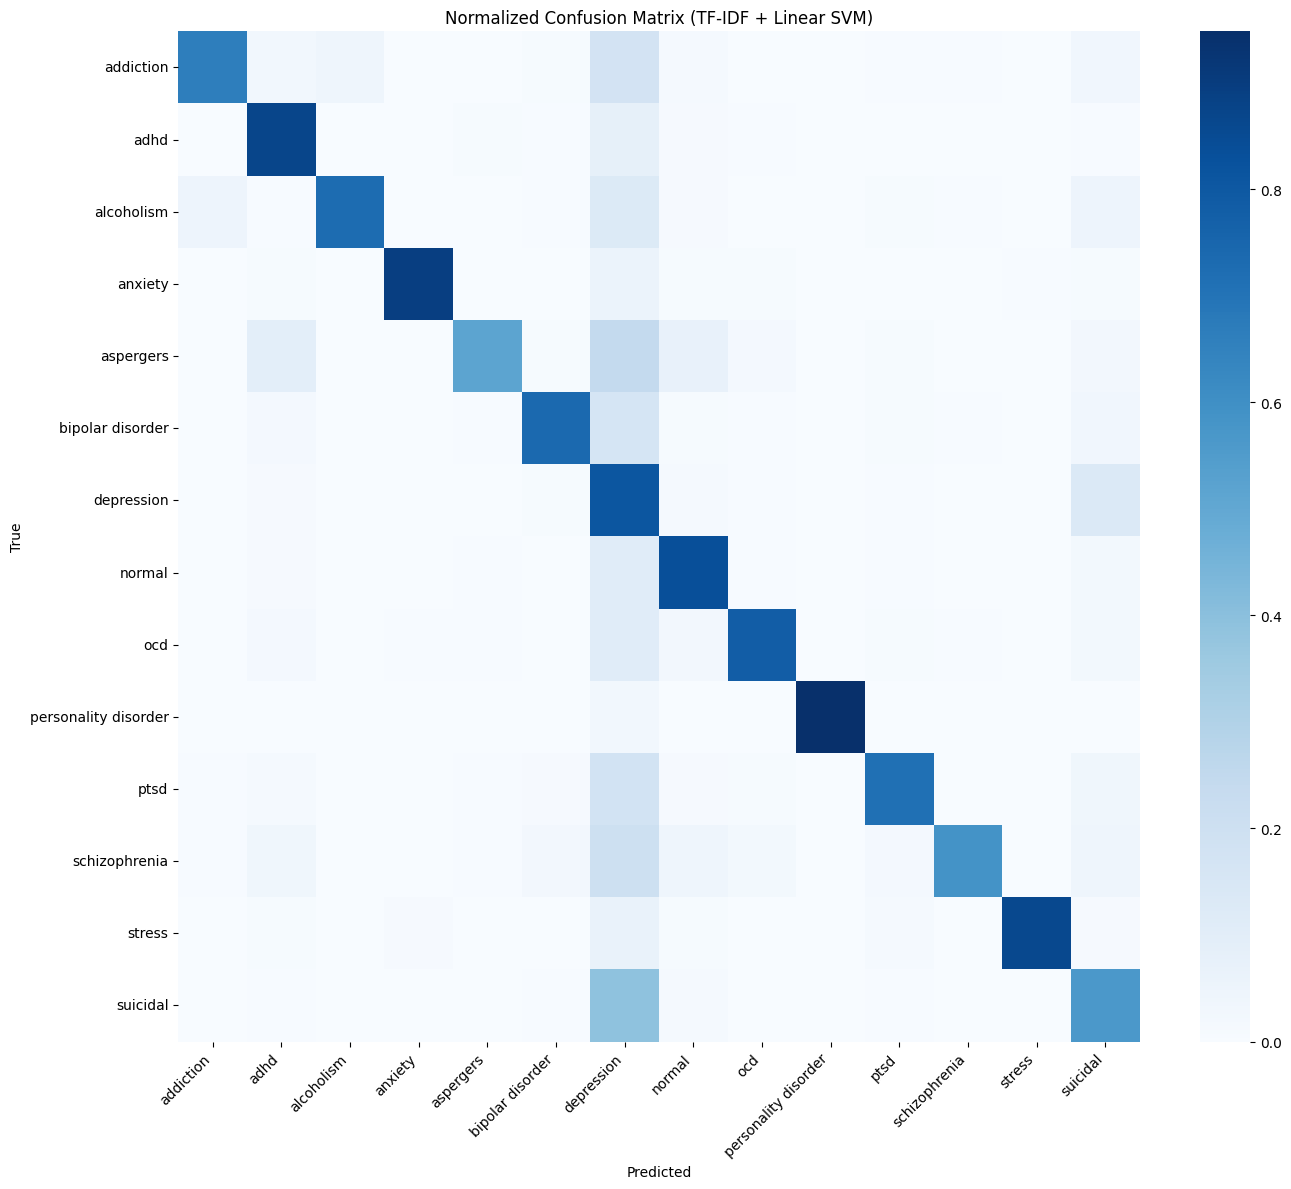

In [36]:
cm = confusion_matrix(y_val, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_norm,
    xticklabels=id2label.values(),
    yticklabels=id2label.values(),
    cmap="Blues",
    annot=False
)
plt.title("Normalized Confusion Matrix (TF-IDF + Linear SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


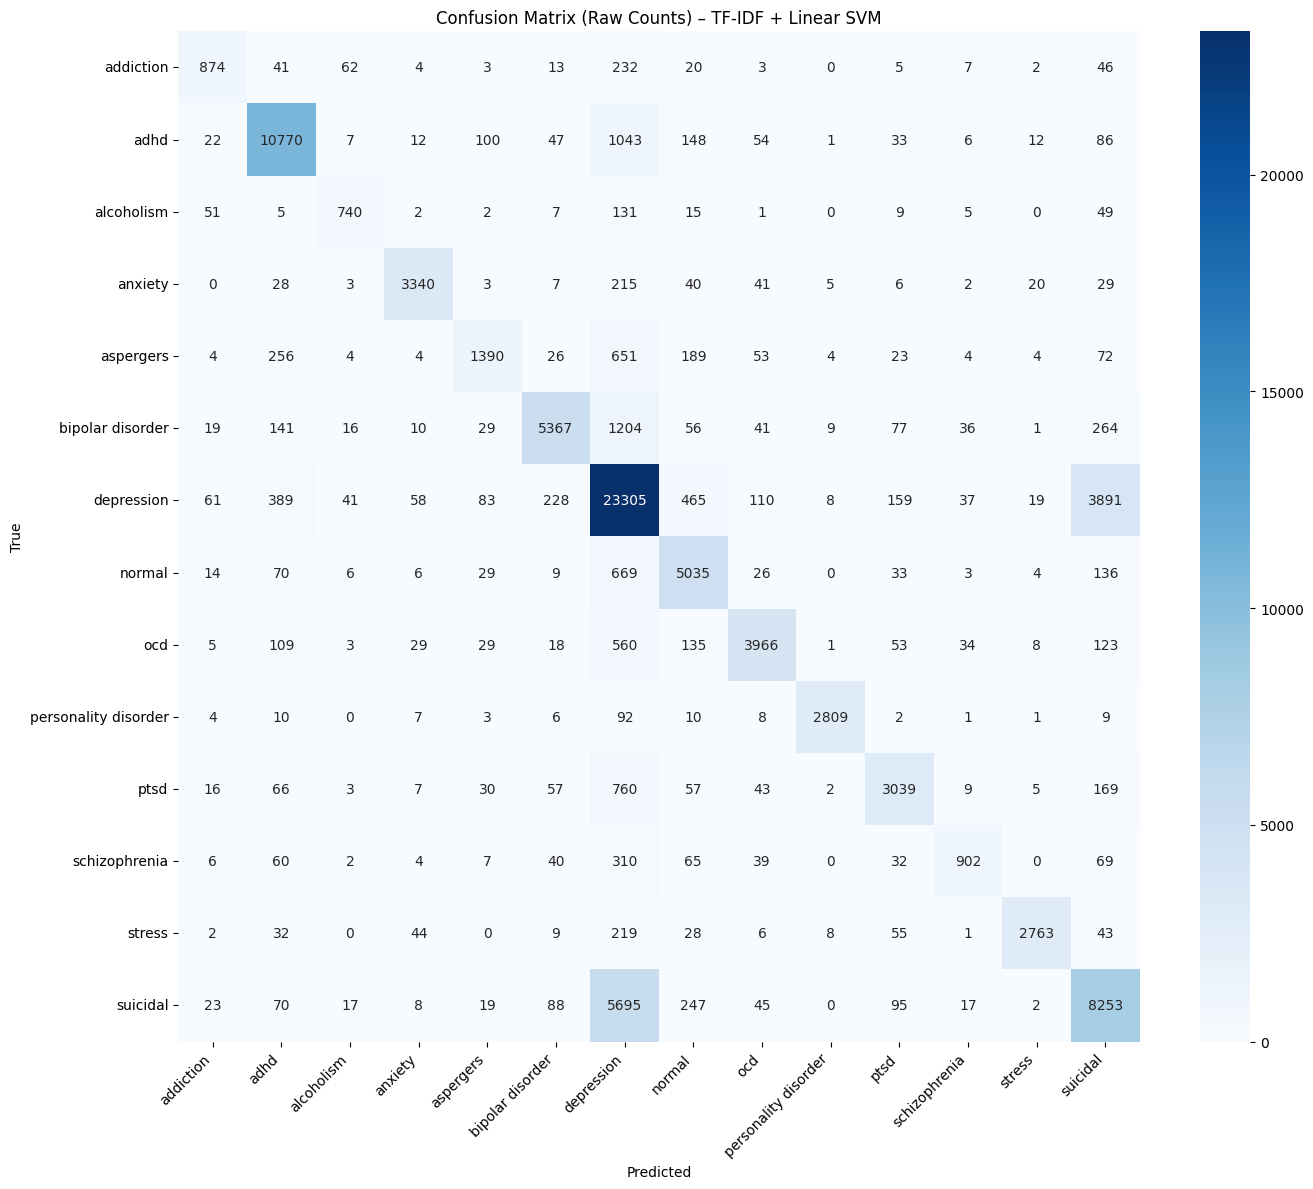

In [37]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    xticklabels=id2label.values(),
    yticklabels=id2label.values(),
    cmap="Blues",
    annot=True,
    fmt="d"
)
plt.title("Confusion Matrix (Raw Counts) – TF-IDF + Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


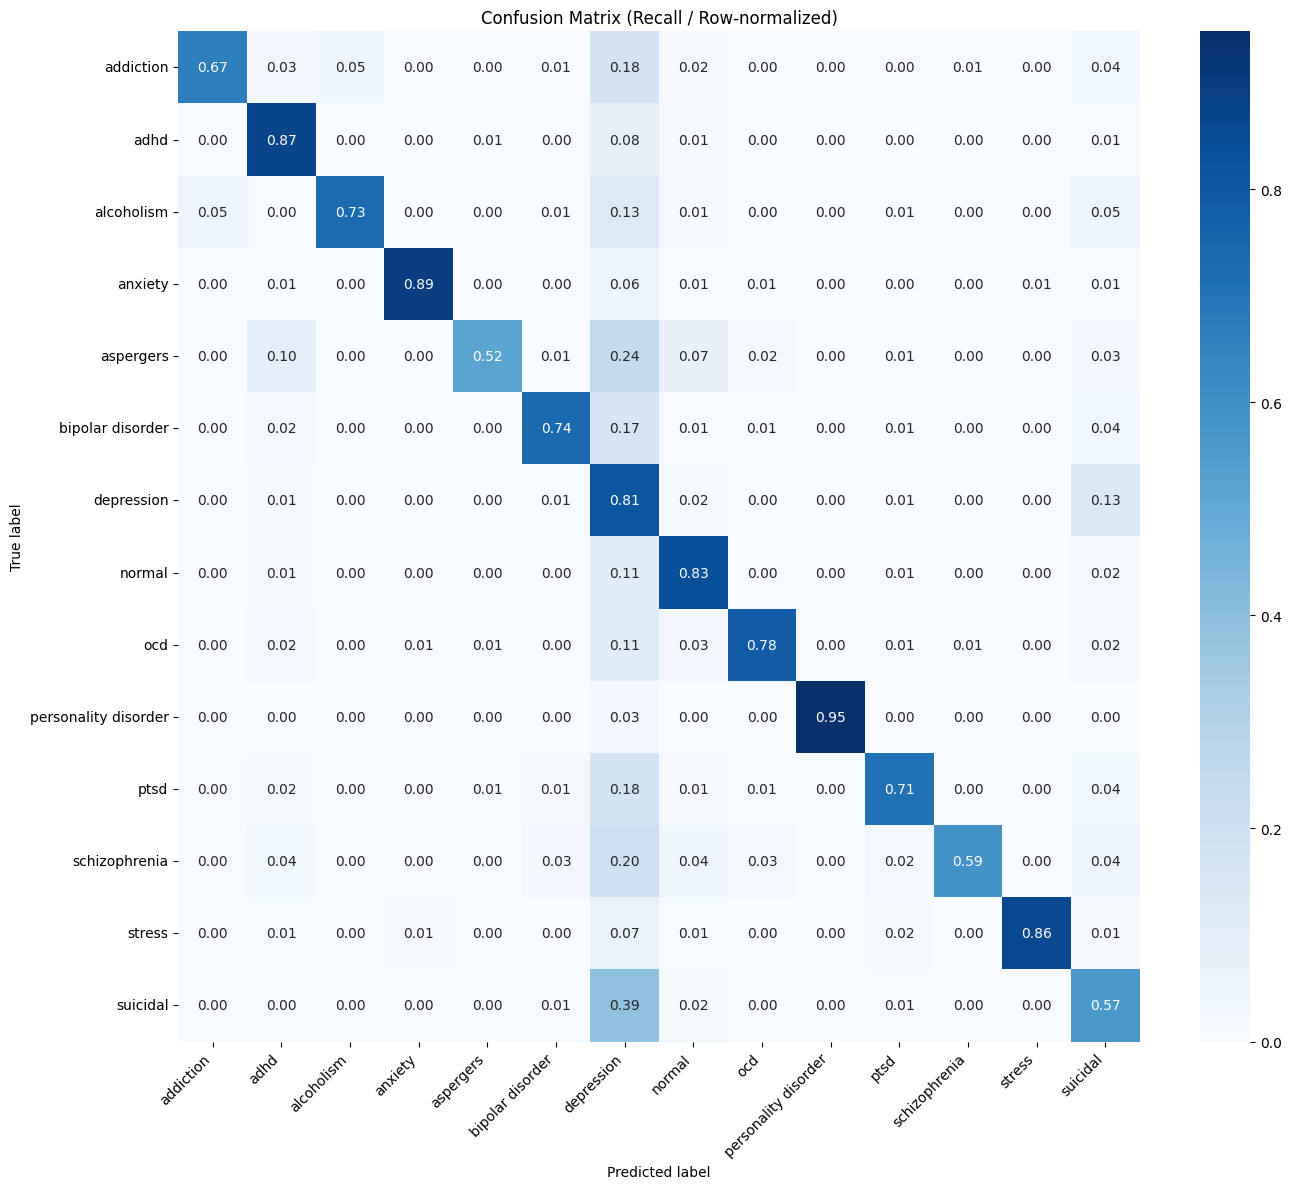

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix (raw counts)
cm = confusion_matrix(y_val, y_pred)

# Normalize by rows → recall per class
cm_recall = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_recall,
    xticklabels=id2label.values(),
    yticklabels=id2label.values(),
    cmap="Blues",
    annot=True,        # show numbers
    fmt=".2f",         # 2 decimals (percent-like)
    cbar=True
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Recall / Row-normalized)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [39]:
report = classification_report(
    y_val, y_pred,
    target_names=[id2label[i] for i in range(len(labels_list))],
    digits=4,
    output_dict=True
)

with open("svm_evaluation_results1.json", "w") as f:
    json.dump(report, f, indent=2)

print("Saved: svm_evaluation_results1.json ")


Saved: svm_evaluation_results1.json 


In [40]:
import joblib

joblib.dump(svm, "svm_tfidf_model1.joblib")
joblib.dump(tfidf, "tfidf_vectorizer1.joblib")

print("Saved: svm_tfidf_model1.joblib and tfidf_vectorizer1.joblib ")


Saved: svm_tfidf_model1.joblib and tfidf_vectorizer1.joblib 


In [44]:
!zip -r svm_outputs1.zip svm_evaluation_results1.json svm_tfidf_model1.joblib tfidf_vectorizer1.joblib
print("Created: svm_outputs1.zip ")


  adding: svm_evaluation_results1.json (deflated 68%)
  adding: svm_tfidf_model1.joblib (deflated 16%)
  adding: tfidf_vectorizer1.joblib (deflated 69%)
Created: svm_outputs1.zip 


In [42]:
text = "I feel hopeless and I don't want to live anymore"

x = tfidf.transform([text])
probs = svm_calibrated.predict_proba(x)[0]

topk = probs.argsort()[::-1][:5]
for i in topk:
    print(f"{id2label[i]} → probability={probs[i]:.3f}")


suicidal → probability=0.788
depression → probability=0.116
ocd → probability=0.049
ptsd → probability=0.014
aspergers → probability=0.010
